# Глубинное обучение для текстовых данных, ФКН ВШЭ

## Домашнее задание 1: векторые представления слов

### Оценивание и штрафы

Максимально допустимая оценка за работу — 13 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Весь код должен быть написан самостоятельно. Чужим кодом для пользоваться запрещается даже с указанием ссылки на источник. В разумных рамках, конечно. Взять пару очевидных строчек кода для реализации какого-то небольшого функционала можно.

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

Это задание посвящено получению векторных представлений слов. Вам предстоит самостоятельно реализовать Count-based методы и Word2Vec в его вариации Skip-gram + Negative Sampling, а затем обучить их на датасетах русских и белорусских текстов. Оба корпуса достаточно большие. Поэтому, чтобы сэкономить время на их обработке, старайтесь писать наиболее оптимальный код и избегать лишних циклов. Если ваши матрицы считаются дольше 10 минут, то вы точно сделали что-то не так.

Для сдачи задания необходимо дописать весь код, недостающий в файлах `utils.py` и `embedding_models.py` и выдолнить задания из данного ноутбука. Если вам удобнее оформить код иначе, переписав функции или создав дополнительные файлы, то вы можете это сделать. В anytask в таком случае необходимо загрузить все файлы с кодом. Прежде чем что-то имплементировать, аккуратно продумайте, как лучше организовать код.


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np

from utils import plot_embeddings, eval_simlex

from bokeh.io import output_notebook
output_notebook()

In [ ]:
be = open('be.txt', 'r').read()

In [ ]:
be_texts = be.split('\n\n')

In [ ]:
len(be_texts)

In [ ]:
mean_be_len = np.mean([len(text) for text in be_texts])

In [ ]:
mean_be_len

In [ ]:
ru_texts = []
for file in os.listdir('big_russian_texts'):
    with open(f'big_russian_texts/{file}', 'r') as f:
        ru_texts.append(f.read())

In [ ]:
vk_ru = open('big_russian_texts/vktexts.txt', 'r').read()

In [ ]:
texts = vk_ru.split('\n')[1::2][:10]

In [ ]:
texts = vk_ru.split('\n')

In [ ]:
texts[1]

In [ ]:
# re.sub('<.*?>', '', string)
re.sub(r'\[.*\|.*\]', '', texts[1])

In [ ]:
len(texts)

In [ ]:
len(texts[2])

In [ ]:
clear_texts = []
for text in texts:
    if 'databaseitem' in text.lower():
        if len(text) > 50:
            print(text)
        continue

    clean_text = re.sub(r'\[.*\|.*\]', '', text)
    if len(clean_text) == 0:
        continue
    clear_texts.append(clean_text)

In [ ]:
mean_ru_len = np.mean([len(text) for text in clear_texts])

In [ ]:
mean_ru_len

In [ ]:
mean_be_len = np.mean([len(text) for text in be_texts])
mean_be_len

In [ ]:
613263 * 355 / 1754 / 2

In [ ]:
be_texts = be_texts[:62060]

In [ ]:
be_df = pd.DataFrame(data={'text': be_texts})
be_df.to_csv('be.csv')

In [ ]:
ru_df = pd.DataFrame(data={'text': clear_texts})
ru_df.to_csv('vk_ru.csv')

In [ ]:
ru_df = pd.DataFrame(data={'text': ru_corpus})
ru_df.to_csv('ru_tokenized.csv')

In [ ]:
be_df = pd.DataFrame(data={'text': be_corpus})
be_df.to_csv('be_tokenized.csv')

### Предобработка текста

__Задание 1 (0.5 балла)__ В файлах `ru.csv` и `be.csv` содержатся тексты собранные из постов в vk.com и белорусского Common Crawl соответственно. В этом задании требуется прочитать и токенизировать эти данные, реализовав функции `read_corpus` и `tokenize` в файле `utils.py`. Для токенизации приведите текст к нижнему регистру, удалите всю пунктуацию и поделите текст по пробелам. Уникальных слов в корпусах довольно много, поэтому, чтобы уменьшить их количество, воспользуйтесь [лемматизацией](https://ru.wikipedia.org/wiki/Лемматизация). Методы лемматизации реализованны во многих библиотеках. Например, nltk, pymorphy2, gensim и так далее. Однако мы рекомендуем использовать [`pymystem3.Mystem`](https://pypi.org/project/pymystem3/), так как этот метод работает быстрее за счет способности обрабатывать сразу много слов. Лемматизация всего текста все равно может занять десятки минут, поэтому советуем сохранить обработанный текст в отдельных файл, чтобы не ждать каждый раз заново.


In [ ]:
# your code here

In [ ]:
from utils import tokenize

tokenized = tokenize('— Ты, верно, задаешься вопросом, зачем я привел тебя сюда.')

assert tokenized == ['ты', 'верно', 'задаешься', 'вопросом', 'зачем', 'я', 'привел', 'тебя', 'сюда']

In [ ]:
ru_corpus = read_corpus('ru')
be_corpus = read_corpus('be')

__Задание 2 (0.5 балла)__ Для того, чтобы строить эмбеддинги, нам еще нужно собрать словарь слов. Чтобы словарь не разросся до неконтролируемых размеров, будем класть в него только те, слова, которые встречаются в корпусе хотя бы 10 раз. Реализуйте функцию `get_distinct_words` в файле `utils.py`. Она принимает в себя корпус токенизированного текста и параметр `min_count`, который отвечает за отсеивание редких слов. На выход функция возвращает набор уникальных слов, отсортированных по убыванию частоты встречаемости, а так же счетчик вхождения каждого слова из тех, _что встречались не меньше `min_count` раз_.

In [ ]:
from utils import get_distinct_words

bart_texts = [
    'Я больше не буду тратить мел.',
    'Я не буду кататься на скейте по зданию школы.',
    'Я не буду рыгать в классе.',
    'Я не буду провоцировать революцию в школе.',
    'Я не буду рисовать голых девушек в классе.',
    'Я не видел Элвиса.',
    'Я не буду называть свю учительницу "Горячие пирожные".',
    'Жвачка с чесноком - это не смешно.',
    'Они смеются надо мной, а не со мной.',
    'Я не буду кричать "ПОЖАР!" в заполненном классе.'
]
bart_texts = [tokenize(text) for text in bart_texts]
bart_words, counter = get_distinct_words(bart_texts, min_count=2)

assert bart_words == ['не', 'я', 'буду', 'в', 'классе', 'мной']
assert counter['не'] == 10
assert len(counter) == 6

### Векторные представления

Сфокусируемся пока что на эмбеддингах для __русского текста__ и будем производить все эксперименты __только с ними__. Все методы для получения эмбеддингов мы будем создавать, наследуясь от класса `gensim.models.KeyedVectors`. Это позволит нам автоматически получить дополнительный функционал для работы с эмбеддингами, например, нахождения ближайших слов. Для чистоты сравнения зафиксируем для всех методов размер эмбеддингов равным 100 и размер контекстного окна равным 5 (то есть 5 слов слева и справа от центрального).

#### Co-Occurrence
Начнем с простейшего Count-based метода - Co-Occurrence. Он строит квадратную матрицу $M$ с размером `[vocab_size x vocab_size]`, в которой $M_{ij}$ равняется тому, сколько раз слово $w_j$
встретилось в контексте слова $w_i$ во всем корпусе. После получения матрицы, ее размерность уменьшается с помощью [TruncatedSVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD).


__Задание 3 (1 балл)__ Начнем с получения матрицы совместной встречаемости. Реализуйте функцию `compute_co_occurrence_matrix` в файле `embedding_models.py`. Она принимает в себя корпус текста и размер окна `window_size`. Слово $w_j$ считается лежащим в контексте слова $w_i$, если оно находится не дальше `window_size` токенов от него.

In [ ]:
from embedding_models import CoOccurenceEmbeddings

co_occurence = CoOccurenceEmbeddings(bart_texts, min_count=2, window_size=2, vector_size=3)

co_occurence_matrix = np.array([
       [0., 8., 7., 0., 0., 2.],
       [8., 0., 6., 0., 0., 0.],
       [7., 6., 0., 1., 0., 0.],
       [0., 0., 1., 0., 3., 0.],
       [0., 0., 0., 3., 0., 0.],
       [2., 0., 0., 0., 0., 0.]
])

assert np.allclose(co_occurence.matrix, co_occurence_matrix)

__Задание 4 (0.5 балла)__ Осталось понизить ранг полученной матрицы, чтобы векторные представления стали разумного размера. Для этого реализуйте функцию `reduce_to_k_dim` из того же файла. В случаях, когда размерность уменьшается значительно (прямо как у нас), вместо того, чтобы находить полное SVD разложение, а потом обрезать полученные матрицы, можно находить векторы матрицы покомпонентно. Лучше всего данный метод реализован в классе `sklearn.decomposition.TruncatedSVD`, поэтому советуем им воспользоваться.

In [ ]:
co_occurence = CoOccurenceEmbeddings(bart_texts, min_count=2, window_size=2, vector_size=3)

vectors = np.array([
       [8.56666408,  6.54357573, -0.86071724],
       [8.10934897, -4.67083255, -3.50835314],
       [7.7126616 , -2.13422259,  4.66818192],
       [0.57038104,  0.28829452, -1.03139741],
       [0.12086354, -0.10215964,  0.51391078],
       [1.21018209, -1.54584819,  0.28591105]
])

assert np.allclose(co_occurence.vectors, vectors)

Для проверки того, что за эмбеддинги у нас получились, мы будем каждый раз проводить качественный и количественный анализ. Качественный анализ будет заключаться в рисовании t-SNE для эмбеддингов, а количественный анализ мы будем производить на бенчмарке [__SimLex-999__](https://fh295.github.io/simlex.html), обрезанном так, чтобы все слова присутствавали в нашем словаре. Для построения графика в файле `utils.py` реализован метод `plot_embeddings`, а для запуска теста на бенчмарке — `eval_simlex`.

__Задание 5 (0.5 балла)__ Замерьте качество полученных эмбеддингов двумя описанными способами. Если у вас получилось занчение корреляции больше 0.1, то вы все сделали правильно. Что вы можете сказать о результатах? Получились ли какие-то кластеры слов? Есть ли слова, которые должны были лежать в одном кластере, но не лежат? Как вы думает, почему так вышло?

In [ ]:
# your code here

#### Positive Pointwise Mutual Information (PPMI)

[PPMI](https://en.wikipedia.org/wiki/Pointwise_mutual_information#Positive_PMI) — это улучшенный вариант метода Co-Occurrence. В нем считается матрица того же размера, однако вместо количества совместных встречаний, на каждой позиции стоит логарифм отношения совместной вероятности слов к произведению вероятностей каждого из этих слов.

$$
PPMI(w_i, w_j) = \max\left(0, \log \frac{p(w_i, w_j)}{p(w_i)p(w_j)}\right)
$$

__Задание 6 (1 балл)__ Реализуйте функцию `compute_ppmi_matrix` в файле `embedding_models.py`. Для подсчета вероятностей переиспользуйте метод `compute_co_occurrence_matrix`, после этого PPMI матрицу можно получить без использования циклов.

In [ ]:
from embedding_models import PPMIEmbeddings

ppmi = PPMIEmbeddings(bart_texts, min_count=2, window_size=2, vector_size=3)

ppmi_matrix = np.array([
       [0.  , 1.22, 1.22, 0.  , 0.  , 1.22],
       [1.22, 0.  , 1.29, 0.  , 0.  , 0.  ],
       [1.22, 1.29, 0.  , 0.19, 0.  , 0.  ],
       [0.  , 0.  , 0.19, 0.  , 2.14, 0.  ],
       [0.  , 0.  , 0.  , 2.14, 0.  , 0.  ],
       [1.22, 0.  , 0.  , 0.  , 0.  , 0.  ]
])

assert np.allclose(ppmi.ppmi_matrix.round(2), ppmi_matrix)

__Задание 7 (0.25 балла)__ Замерьте качество для новых эмбеддингов теми же двумя способами. Изменился ли результат? Как вы думаете, почему PPMI лучше или хуже Co-Occurrence?

In [ ]:
# your code here

#### Word2Vec

В этой секции вам предстоит обучить модель Skip-gram + Negative Sampling. 

Перед обучением собирается набор пар слов $\{w_i, w_j\}$ с помощью прохода по тексту окном определенного размера. В каждой паре слово $w_i$ является центральным в окне, а $w_j$ – другое слово в том же окне. В процессе обучения оптимизируются параметры дву матриц: $U$ и $V$. Обе матрицы содержат эмбеддинги всех слов, однако матрица $U$ используется, когда слово стоит на центральном месте, а $V$ – когда слово является контекстом другого. Ошибка считается по формуле

$$
L(U, V) = \sum_{i, j \in Batch} \Big[ -\log \sigma(U_i^T V_j) - \sum_{k \in Neg_i} \log \sigma(-U_i^T V_k)\Big],
$$
где $\sigma$ – сигмоида, а $Neg$ – набор негативных слов.

__Задание 8 (0.5 балла)__ Выведите формулы для подсчета градиентов векторов $U_i$ и $V_j$.

ОТВЕТ ЗДЕСЬ

Оригинальная реализация из библиотеки gensim написана на cpython с использованием параллельных потоков. Поэтому, если вы решитесь писать весь код на numpy, обучение займет у вас очень много часов. Однако, если вы сможете добавить распараллеливание и сократите время обучения до адекватного, то мы обязательно подарим вам бонусных баллов за отвагу. Если же настолько много храбрости в вас нет, то напишите код на pytorch и учите с использованием GPU.

__Задание 8 (2 балла)__ Реализуйте метод `train` в классe `Word2Vec`. В этом задании мы не даем вам шаблон пайплайна, так как реализовавать данный метод можно огромным числом разных способов, и мы даем вам полную свободу в дизайне вашего решения. Вы так же можете менять любые гиперпараметры по вашему усмотрению, кроме размера эмбеддингов и размера окна. Обучайте модель не меньше 5 эпох (то есть не меньше 5 прогонов по всему корпусу текстов). Для проверки качества можете обучить модель Word2Vec из библиотеки gensim и сравнить с тем, что получается у вас. Автору данного задания удалось достичь значение корреляции 0.152.

__Задание 9 (0.25 балла)__ Замерьте качество обученного Word2Vec. Можно ли увидеть глазами разницу между распределениями эмбеддингов, полученных этим методом и двумя предыдущими?

In [ ]:
# your code here

### Машинный перевод

В 2013 году создатель Word2Vec, Tomas Mikolov, заметил, что эмбеддинги слов для разных языков обладают похожей структурой. При этом оказалось, что, возпользовавшись этой похожестью, можно обучить довольно точное линейное преобразование $W$ для переноса эмбеддингов из исходного пространства в пространство нового языка. Таким образом, мы получаем простейший метод для перевода произвольных слов с одного языка на другой.

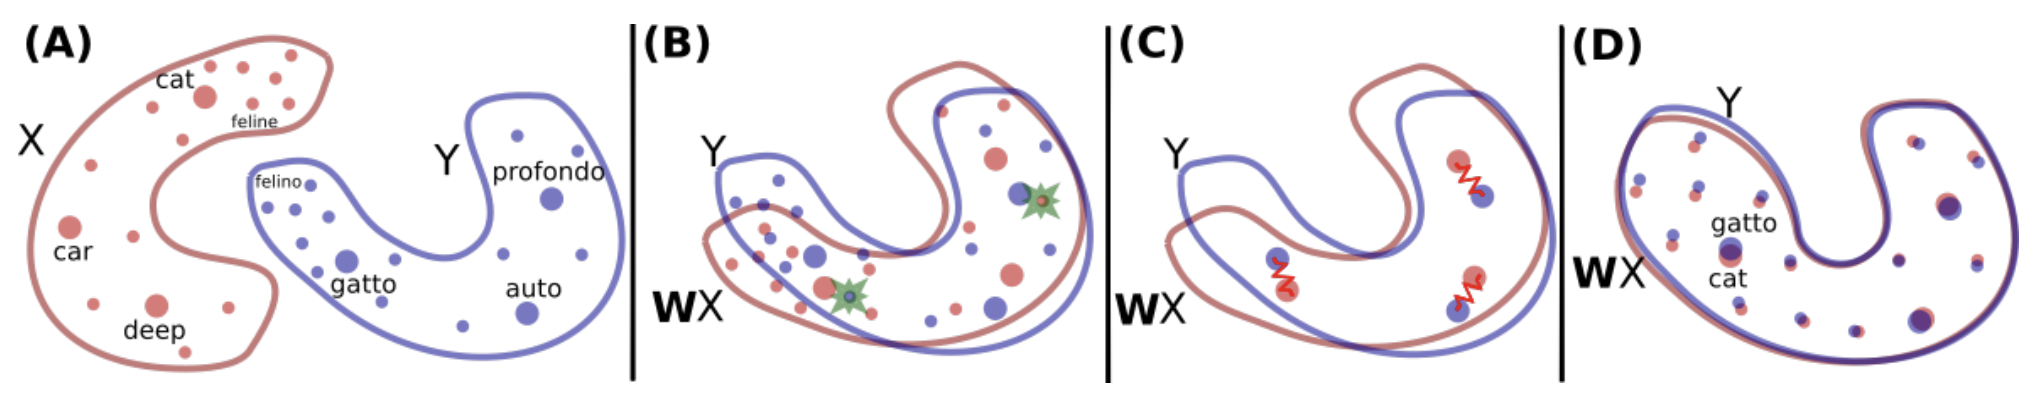

Единственный вопрос заключается в том, как лучше обучать такое преобразование. Tomas Mikolov в оригинальной статье решал так называемую задачу [Прокруста](https://ru.wikipedia.org/wiki/Прокруст).

$$
W^* = \underset{W}{argmin} \sum_i \|x_i^T W - y_i\|_2^2 = \underset{W}{argmin} \|X W - Y\|_F^2,
$$
где $X$ – эмбеддинги слов исходного языка, $Y$ – эмбеддинги их переводов на новый язык, $\|*\|_F$ – норма Фробениуса.

__Задание 10 (0.5 балла)__ Обучите лучший из ваших методов на корпусе русского и белорусского языков.

In [ ]:
ru_model = <your best model trained on Russian corpus>
be_model = <your best model trained on Belarusian corpus>

Соберем датасет пар слов на русском и белорусском языках.

In [ ]:
def load_word_pairs(filename):
    ru_be_pairs = []
    ru_vectors = []
    be_vectors = []
    with open(filename, "r") as f:
        for line in f:
            ru, be = line.rstrip().split("\t")
            if ru not in ru_model or be not in be_model:
                continue
            ru_be_pairs.append((ru, be))
            ru_vectors.append(ru_model[ru])
            be_vectors.append(be_model[be])
    return ru_be_pairs, np.array(ru_vectors), np.array(be_vectors)

In [ ]:
ru_be_train, X_train, Y_train = load_word_pairs("ru_be.train.txt")
ru_be_test, X_test, Y_test = load_word_pairs("ru_be.test.txt")

__Задание 11 (0.5 балла)__ Обучите матрицу $W$ для преобразования эмбеддингов согласно задаче Прокруста. Тут можно воспользоваться обычной линейной регрессией из `sklearn`.

In [ ]:
from sklearn.linear_model import LinearRegression

mapping = # your code here

In [ ]:
translation = mapping.predict(ru_model['телевизор'].reshape(1, -1))
be_model.most_similar(translation, topn=10)

Для оценки качества перевода будем считать __precision@k__ от предсказаний слов. А точнее, мы будем использовать __precision@1__ и __precision@5__, чтобы лучше следить за изменениями обученном преобразовании.

$$
precision@k = \frac{1}{N} \sum_{i=1}^N \sum_{j=1}^k [\hat{Y}_{ij} = Y_i],
$$
где $\hat{Y}_i$ – вектор предсказаний слов, отсортированных по убыванию вероятности, $Y_i$ – верное слово.

__Задание 12 (0.5 балла)__ Допишите функцию `precision`.

In [ ]:
def precision(pairs, mapped_vectors, topn=1):
    """
    :args:
        pairs = list of right word pairs [(ru_word_0, be_word_0), ...]
        mapped_vectors = list of embeddings after mapping from source embedding space to destination embedding space
        topn = the number of nearest neighbours in destination embedding space to choose from
    :returns:
        precision_val, float number, total number of words for those we can find right translation at top K.
    """
    assert len(pairs) == len(mapped_vectors)

    for i, (_, true_be) in enumerate(pairs):
       # your code here

    return precision_val

In [ ]:
precision_top1 = precision(ru_be_test, mapping.predict(X_test), 1)
precision_top5 = precision(ru_be_test, mapping.predict(X_test), 5)
precision_top1, precision_top5

In [ ]:
assert precision_top1 > 0.18
assert precision_top5 > 0.3

#### Ортогональная задача Прокруста

В [статье 2015 года](https://aclanthology.org/N15-1104/) было показано, что перевод получается лучше, если наложить условия ортогональности на матрицу $W$, и, как следствие, решать ортогональную задачу Прокруста.

$$
W^* = \underset{W}{argmin} \|X W - Y\|_F^2, \text{ where } W^TW = I
$$

Для такой задачи существует [точное решение](https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem), которое можно получить с помощью SVD разложения.

$$
W^* = UV^T, \text{ where } U\Sigma V^T = X^T Y
$$

__Задача 13 (0.5 балла)__ Допишите функцию `orthogonal_transform`, которая находит искомую матрицу $W$ с помощью SVD разложения.

In [ ]:
def orthogonal_transform(X_train, Y_train):
    """ 
    :returns: W* : float matrix[emb_dim x emb_dim] as defined in formulae above
    """
    
    # your code here

In [ ]:
W = orthogonal_transform(X_train, Y_train)

In [ ]:
precision_top1 = precision(ru_be_test, X_test @ W, 1)
precision_top5 = precision(ru_be_test, X_test @ W, 5)
precision_top1, precision_top5

#### Машинный перевод

Итак, мы проделали все подготовительные шаги и теперь, наконец, можем реализовать свой собственный (не очень хороший) переводчик! Для этого нам нужно дописать пару функций, которые для каждого слова находят наиболее подходящий перевод.

__Задание 14 (0.5 балла)__ Допишите функции `closest_be_word` и `translate`.

In [ ]:
def closest_be_word(W, ru_emb):
    """
    :returns: word : closest translation of the source word's embedding (ru_emb)
    """
    # your code here
    pass

def translate(ru_text):
    """
    :returns: be_text : list of lists of word by word translations
    """
        
    return be_text

In [ ]:
from utils import tokenize

with open("balalayki.txt", "r") as f:
    ru_text = [tokenize(line.strip()) for line in f]

In [ ]:
be_text = translate(ru_text)

In [ ]:
for line in be_text:
    print(' '.join(line))

__Задание 15 (0.5 балла)__ Скорее всего качество перевода вас не удовлетворило, поэтому попробуйте загрузить предобученные эмбеддинги с [сайта fastText](https://fasttext.cc/docs/en/crawl-vectors.html) и перевести тот же текст с их помощью. Загрузка эмбеддингов может занять минут 5, так что не пугайтесь. Посчитайте значение precision@k и переводите текст. Стало ли лучше?

In [ ]:
import numpy as np
from gensim.models import KeyedVectors, Word2Vec

In [ ]:
ru_model = KeyedVectors.load_word2vec_format("cc.ru.300.vec", limit=250000)
be_model = KeyedVectors.load_word2vec_format("cc.be.300.vec", limit=250000)

In [ ]:
ru_be_train, X_train, Y_train = load_word_pairs("ru_be.train.txt")
ru_be_test, X_test, Y_test = load_word_pairs("ru_be.test.txt")

In [ ]:
# your code here

__Бонус (3 балла): Перевод без параллельного корпуса слов__

В [этой статье](https://arxiv.org/pdf/1710.04087.pdf) предлагается метод обучения матрицы $W$ без корпуса переводов слов. Делается это с помощью состязательного функционала ошибки. Попробуйте реализовать предложенный метод (только то, что описано в секции 2.1) и замерьте качество на тестовой выборке с помощью precision@k. Получилось ли у вас достичь качества преобразования, обученного с учителем?